# Machine learning prediction model for Canadian cheese fat level content.

All the required libraries will be imported.

In [1]:
import pandas as pd
import numpy as np
import altair as alt

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import make_scorer
from sklearn.svm import SVC, SVR
from scipy.stats import lognorm, loguniform, randint
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Introduction

The Canadian dairy industry is a major economic sector, with cheese production representing one of its most significant outputs; reaching approximately 500,000 tons in 2024 alone (Agriculture Canada, 2025). Cheese quality and type depend heavily on milk fat content, which in turn is influenced by factors such as cow breed, milk treatment, and production methods.

The goal of this project is to develop a machine learning model capable of predicting whether a cheese sample is classified as low fat or high fat based on several explanatory features, including the province of manufacture, milk type, production category, and other relevant characteristics. The expected outcome is a model that can accurately identify the majority of low-fat cheeses while maintaining generalization to unseen data.

Given that the target variable (“fat level”) consists of discrete categories — low fat and high fat — this problem is formulated within the framework of supervised machine learning as a classification task.


# Exploratory Data Analysis
The dataset will be loaded and some initial information will be gathered.

In [2]:

cheese_df = pd.read_csv('data/cheese_data.csv')
cheese_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              1042 non-null   int64  
 1   ManufacturerProvCode  1042 non-null   object 
 2   ManufacturingTypeEn   1042 non-null   object 
 3   MoisturePercent       1028 non-null   float64
 4   FlavourEn             801 non-null    object 
 5   CharacteristicsEn     643 non-null    object 
 6   Organic               1042 non-null   int64  
 7   CategoryTypeEn        1019 non-null   object 
 8   MilkTypeEn            1041 non-null   object 
 9   MilkTreatmentTypeEn   977 non-null    object 
 10  RindTypeEn            721 non-null    object 
 11  CheeseName            1042 non-null   object 
 12  FatLevel              1042 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 106.0+ KB


The dataset contains 1,042 cheese samples with 13 variables. Most columns are categorical, while only two (CheeseId and MoisturePercent) are numeric. The remaining columns are classified as object. Several of these features have null values that will be described in the following section.

Let us determine which features have a large proportion of null values.

In [3]:
has_null_count = cheese_df.isnull().sum()
has_null_count

CheeseId                  0
ManufacturerProvCode      0
ManufacturingTypeEn       0
MoisturePercent          14
FlavourEn               241
CharacteristicsEn       399
Organic                   0
CategoryTypeEn           23
MilkTypeEn                1
MilkTreatmentTypeEn      65
RindTypeEn              321
CheeseName                0
FatLevel                  0
dtype: int64

Features such as FlavourEn, CharacteristicsEn, and RindTypeEn were excluded due to extensive missing data, which could bias the model or reduce training reliability. The other one is just a series of numbers that will not contribute any value in this ML project 'CheeseID'.

Overall, the dataset exhibits moderate missingness, primarily in categorical fields describing sensory properties. This may indicate incomplete metadata entries from manufacturers.

In [4]:
#Table 1: Cheese dataframe
cheese_df = cheese_df.drop(columns=['CheeseId','FlavourEn', 'CharacteristicsEn', 'RindTypeEn'])
cheese_df.head(5)

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,Sieur de Duplessis (Le),lower fat
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,Tomme Le Champ Doré,lower fat
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,Provolone Sette Fette (Tre-Stelle),lower fat
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,Geai Bleu (Le),lower fat
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,Gamin (Le),lower fat


In [5]:
print(cheese_df.dtypes)

ManufacturerProvCode     object
ManufacturingTypeEn      object
MoisturePercent         float64
Organic                   int64
CategoryTypeEn           object
MilkTypeEn               object
MilkTreatmentTypeEn      object
CheeseName               object
FatLevel                 object
dtype: object


### Exploratory Visualizations
To better understand the characteristics of the dataset, a series of visualizations were created. A custom function (plot_value_counts) was developed to summarize the distribution of categorical features by counting their occurrences and generating corresponding bar charts using Altair. These visualizations allow for a clearer examination of category frequency, potential imbalance, and feature diversity within the dataset. A summary of the observed trends is presented below.

In [6]:
#Figure 1: Manufacturer's number count per Canadian province

from plot_value_counts import plot_value_counts
plot_chart1= plot_value_counts(cheese_df, 'ManufacturerProvCode', color='green', title="Manufacturer's number per province",
                               x_title= 'Canada Provinces')
plot_chart1

alt.Chart(...)

In [7]:
#Figure 2: Manufacturer cheese type number counts 
plot_chart2 = plot_value_counts(cheese_df, 'ManufacturingTypeEn', color='orange', title="Manufacturer's type number counts",
                               x_title='Manufacturer type')
plot_chart2

alt.Chart(...)

In [8]:
#Figure 3: Cheese category number counts
plot_chart3 = plot_value_counts(cheese_df, 'CategoryTypeEn', color='red', title="Cheese Category number counts",
                               x_title='Cheese Category')
plot_chart3

alt.Chart(...)

In [9]:
#Figure 4:Milk animal type number counts 
plot_chart4 = plot_value_counts(cheese_df, 'MilkTypeEn', color='magenta', title="Milk Animal Type vs. number counts",
                               x_title='Milk Animal Type')
plot_chart4

alt.Chart(...)

In [10]:
#Figure 5:Milk Treatment type number counts 
plot_chart5 = plot_value_counts(cheese_df, 'MilkTreatmentTypeEn', color='blue', title="Milk Treatment vs. number counts",
                               x_title='Milk Treatment')
plot_chart5

alt.Chart(...)

Let us plot the numerical features.

In [11]:
#Figure 6:Cheese moisture percentage number counts
plot_chart6 = plot_value_counts(cheese_df, 'MoisturePercent', color='olive', title="Cheese moisture percentage vs. number counts",
                               x_title='Moisture percentage')
plot_chart6

alt.Chart(...)

Let us plot the binary feature

In [12]:
#Figure 7:Cheese organic type number counts
plot_chart7 = plot_value_counts(cheese_df, 'Organic', color='lime', title="Cheese organic type number counts",
                               x_title='Organic type')
plot_chart7

alt.Chart(...)

Finally, I will plot the target column, 'FatLevel'

In [13]:
#Figure 8:Cheese Fat level number counts 
plot_chart8 = plot_value_counts(cheese_df, 'FatLevel', color='gold', title="Cheese Fat level vs. number counts",
                               x_title='Cheese Fat level')
plot_chart8

alt.Chart(...)

# Data Analysis Summary
Looking at the figures above, it can be observed that most features in the dataset are unbalanced. The Manufacturer per Province plot (Figure 1) shows that the majority of samples are concentrated in the province of Quebec. The next feature, Manufacturing Type (Figure 2), displays a less pronounced imbalance, though a large portion of the data corresponds to industrial cheese. Similarly, the Cheese Category feature (Figure 3) reveals that most entries belong to the firm cheese category.

The following features, Milk Animal Type and Milk Treatment (Figures 4 and 5), exhibit comparable patterns, with the majority of cheeses being made from cow’s milk and pasteurized products, respectively. The numerical feature Moisture Percent (Figure 6) is also concentrated around 50%, indicating limited variability.

The Organic feature (Figure 7) shows that most products are non-organic (0), and finally, the target variable FatLevel (Figure 8) is dominated by low-fat cheeses.

In summary, the dataset presents a considerable degree of imbalance across most categorical features, with a few dominant categories representing the majority of observations.

### The Text Special Feature

The CheeseName feature is treated as a text variable since it consists primarily of brand or product names rather than categorical groupings. Unlike the other features, these names are not organized into predefined categories, and most entries are unique. As shown in the dataframe below, only a few cheese names appear more than once such as Fromage en grain, Cheddar, Boerenkaas, and Ménestrel (Le).

This observation justifies including CheeseName in the preprocessing pipeline as a text feature. To transform it, a dedicated text transformer was implemented using FunctionTransformer and CountVectorizer. The FunctionTransformer reshapes the input into a one-dimensional series, ensuring compatibility with the text vectorizer, while CountVectorizer converts the cheese names into numerical features using a bag-of-words representation (limited to 100 features and excluding common English stop words). This approach follows best practices for handling text data in machine learning workflows, as described by Mueller (2023) in Working With Text Data (amueller.github.io).


In [14]:
#Table 2: Cheese name dataframe.
cheesename_df = cheese_df['CheeseName'].value_counts()
cheesename_df = cheesename_df.reset_index()
cheesename_df.columns = ['CheeseName', 'Number']
cheesename_df

,CheeseName,Number
0,Ménestrel (Le),2
1,Cheddar,2
2,Fromage en grain,2
3,Boerenkaas,2
4,Oka,1
...,...,...
1033,ChamPaître (Le),1
1034,Doucerel,1
1035,Jensen Cheese (Wilton Cheese Factory),1
1036,Sabot de Blanchette (Le),1


### Transforming the target feature
To continue with the machine learning project, the target variable will be transformed by replacing the category 'higher fat' with 1 and 'lower fat' with 0 using the .replace() method.

In [15]:
cheese_df['FatLevel'] = cheese_df['FatLevel'].replace({'higher fat': 1, 'lower fat': 0})
cheese_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,Sieur de Duplessis (Le),0
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,Tomme Le Champ Doré,0
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,Provolone Sette Fette (Tre-Stelle),0
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,Geai Bleu (Le),0
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,Gamin (Le),0


### Spliting the data
To maintain the integrity of the modeling process and avoid data leakage, the dataset (cheese_df) was divided into training and testing subsets, with 80% allocated to training (train_df) and 20% to testing (test_df).

In [16]:
train_df, test_df = train_test_split(
    cheese_df, test_size=0.2, random_state=123)
print(train_df.shape)  
print(test_df.shape)


(833, 9)
(209, 9)


In [17]:
#Table 3: Describe the train dataframe.
describe_df = train_df.describe(include='object')
describe_df


,ManufacturerProvCode,ManufacturingTypeEn,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName
count,833,833,813,832,781,833
unique,10,3,6,8,3,830
top,QC,Industrial,Firm Cheese,Cow,Pasteurized,Ménestrel (Le)
freq,635,370,271,596,648,2


The table 3 above summarizes what was described previously in the data analysis section. The train dataset contains 80% of the data and shows that each feature is dominated by a singular character, as exposed in the top row. For example, the Manufacturer provincial code is dominated by Quebec (QC), and the Manufacturing type is mostly industrial, and so on.
Next step, the target will be set up ('FatLevel').

### Defining the Target and Feature Sets
In this step, we separate the target variable (`FatLevel`) from the feature variables to prepare the data for model training and evaluation.

In [18]:
X_train = train_df.drop(columns=['FatLevel'])
y_train = train_df['FatLevel']

X_test = test_df.drop(columns=['FatLevel'])
y_test = test_df['FatLevel']

X_train.head()


,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName
482,QC,Artisan,48.0,0,Semi-soft Cheese,Cow,Pasteurized,Raclette Griffon
896,QC,Artisan,45.0,0,Veined Cheeses,Cow,Pasteurized,Rébellion 1837
421,QC,Industrial,50.0,0,Soft Cheese,Cow,Pasteurized,Mini-Brie
929,BC,Artisan,40.0,0,Semi-soft Cheese,Cow,Pasteurized,Aged Farmhouse
737,QC,Artisan,65.0,0,Fresh Cheese,Cow,Pasteurized,Ricotta (l'Ancêtre)


The features were categorized into numeric (numeric_feats), binary (binary_feats), and categorical (categorical_feats) groups. One particular feature, CheeseName, contains unique names for individual cheeses and is therefore unsuitable as a categorical variable because the entries are not grouped but rather a long list of distinct names (see below).

For this reason, CheeseName is treated as a text feature and transformed into numerical representations using CountVectorizer,  as mentioned previously. This method converts text data into numeric feature vectors, following established practices in text classification (see scikit-learn documentation on CountVectorizer, Meuller A., 2023). The scikit-learn tutorial “Working With Text Data” further demonstrates how text vectorization can be effectively integrated with classification algorithms such as Logistic Regression in a pipeline framework.

### Model selection
Logistic Regression is therefore selected as a baseline model for this study, as it is interpretable, computationally efficient, and suitable for comparison against the baseline DummyClassifier.

### Relationships and Class Imbalance
Preliminary observations indicate potential relationships between several categorical features and the target variable. For instance, cheeses with higher moisture content or produced using pasteurized milk may be more likely to belong to a specific fat level category. However, these relationships will be further examined through model-based feature importance analysis.
The target variable FatLevel is noticeably imbalanced, with a predominance of low-fat cheeses. This imbalance will be considered during model evaluation, and if necessary, class weighting will be applied to mitigate bias toward the majority class.
### Evaluation Metrics
Model performance will be evaluated using accuracy, precision, recall, F1-score. These metrics collectively align with the project’s goal of reliably classifying cheeses by fat level while accounting for class imbalance and misclassification risks.

In [19]:
numeric_feats = ['MoisturePercent']
binary_feats = ['Organic']
categorical_feats = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn']
text_feats = ['CheeseName']

print("numeric_feats:", numeric_feats)
print("binary_feats:", binary_feats)
print("categorical_feats:", categorical_feats)
print("text_feats:", text_feats)

numeric_feats: ['MoisturePercent']
binary_feats: ['Organic']
categorical_feats: ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn']
text_feats: ['CheeseName']


## Preprocessing
To prepare the dataset for modeling, separate preprocessing pipelines were developed for each feature type.

Numeric features were processed using a pipeline that applies a median imputation (SimpleImputer(strategy="median")) to handle missing values, followed by standardization with StandardScaler().

Categorical features were imputed using the most frequent value and encoded through one-hot encoding (OneHotEncoder(dtype=int, handle_unknown="ignore")).

Binary features followed a similar approach, using SimpleImputer(strategy="most_frequent") and OneHotEncoder(drop="if_binary") to ensure consistent encoding.

The text feature (CheeseName) was treated separately using FunctionTransformer to reshape the data and CountVectorizer(max_features=100, stop_words='english') to generate numerical representations through a bag-of-words model.

All these pipelines were combined using make_column_transformer() into a single preprocessing object named preprocessor, which integrates all necessary transformations for numeric, categorical, binary, and text data. This design ensures a modular, reproducible, and scalable preprocessing workflow aligned with scikit-learn’s best practices.

In [20]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler())
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(dtype = int,handle_unknown="ignore"))

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="if_binary",dtype = int))

text_transformer = make_pipeline(
    FunctionTransformer(lambda x: x.squeeze(), validate=False),
    CountVectorizer(max_features=100, stop_words='english')
)
preprocessor = make_column_transformer(
    (numeric_transformer, ['MoisturePercent']),
    (categorical_transformer, ['ManufacturerProvCode', 'ManufacturingTypeEn',
                               'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn']),
    (binary_transformer, ['Organic']),
    (text_transformer, 'CheeseName'))

# Methods and Results
This section outlines the modeling process and presents the results obtained through a series of supervised machine learning experiments, progressing from a simple baseline model to a tuned logistic regression classifier optimized for balanced performance.

## Dummy model
Next step, I will build our base line model using DummyClassifier using strategy="stratified".

In [21]:
#Table 4: Dummy Model Scores.
model =DummyClassifier(strategy="stratified", random_state=123)
dummy_scores = cross_validate(model, X_train, y_train, 
                              cv=5,
                              scoring=['accuracy', 'f1', 'recall', 'precision'],
                              return_train_score=True)
dummy_scores = pd.DataFrame(dummy_scores)
dummy_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.000841,0.001816,0.580838,0.566066,0.375000,0.362031,0.368421,0.359649,0.381818,0.364444
1,0.000478,0.001548,0.604790,0.566066,0.410714,0.362031,0.403509,0.359649,0.418182,0.364444
2,0.000470,0.001741,0.473054,0.569069,0.214286,0.366446,0.210526,0.364035,0.218182,0.368889
3,0.000492,0.001540,0.493976,0.562219,0.250000,0.353982,0.245614,0.350877,0.254545,0.357143
4,0.000468,0.001513,0.566265,0.568216,0.357143,0.362832,0.350877,0.359649,0.363636,0.366071


In [22]:
results_dict = {
    'Dummy': {
        'mean_train_accuracy': round(dummy_scores["train_accuracy"].mean(), 4),
        'mean_validation_accuracy': round(dummy_scores["test_accuracy"].mean(), 4),
        'mean_fit_time (s)': round(dummy_scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(dummy_scores["score_time"].mean(), 4),
        'mean_test_f1': round(dummy_scores["test_f1"].mean(), 4),
        'mean_train_f1': round(dummy_scores["train_f1"].mean(), 4),
        'mean_test_recall': round(dummy_scores["test_recall"].mean(), 4),
        'mean_train_recall': round(dummy_scores["train_recall"].mean(), 4),
        'mean_test_precision': round(dummy_scores["test_precision"].mean(), 4),
        'mean_train_precision': round(dummy_scores["train_precision"].mean(), 4)}}
results_dict

{'Dummy': {'mean_train_accuracy': 0.5663,
  'mean_validation_accuracy': 0.5438,
  'mean_fit_time (s)': 0.0005,
  'mean_score_time (s)': 0.0016,
  'mean_test_f1': 0.3214,
  'mean_train_f1': 0.3615,
  'mean_test_recall': 0.3158,
  'mean_train_recall': 0.3588,
  'mean_test_precision': 0.3273,
  'mean_train_precision': 0.3642}}

## Dummy Classifier Interpretation

The DummyClassifier achieved an average training accuracy of approximately 0.56 (56%) and a validation accuracy of 0.54 (54%), which will serve as the baseline performance for evaluating more advanced models. As expected, the F1, recall, and precision scores were all around 0.30 (30%), reflecting the model’s naive strategy of always predicting the most frequent class in the target variable — in this case, “low fat” (0).

## Logistic Regression model
The next step is to build our model using an unbalanced Logistic Regression approach.

In [23]:
log_reg = LogisticRegression(max_iter=2000)
unbalanced_pipe = make_pipeline(preprocessor, log_reg)
unbalanced_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MoisturePercent']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                        

Next, cross-validation will be conducted to evaluate the model’s performance, and the resulting scores will be extracted for analysis.

In [24]:
#Table 5: Logistic Regression Model unbalanced Scores.
cv_scores = cross_validate(unbalanced_pipe, X_train, y_train,
                           scoring=['accuracy', 'f1', 'recall', 'precision'],
                           cv=5, 
                           return_train_score=True)

lr_scores = pd.DataFrame(cv_scores)

lr_scores


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.020406,0.006338,0.826347,0.858859,0.723810,0.779343,0.666667,0.728070,0.791667,0.838384
1,0.019716,0.006202,0.832335,0.858859,0.730769,0.778302,0.666667,0.723684,0.808511,0.841837
2,0.019053,0.006523,0.832335,0.870871,0.740741,0.799065,0.701754,0.750000,0.784314,0.855000
3,0.020240,0.006260,0.831325,0.854573,0.740741,0.769596,0.701754,0.710526,0.784314,0.839378
4,0.020208,0.006149,0.801205,0.869565,0.707965,0.797203,0.701754,0.750000,0.714286,0.850746


In [25]:
results_dict = {
    'LogReg': {
        'mean_train_accuracy': round(lr_scores["train_accuracy"].mean(), 4),
        'mean_validation_accuracy': round(lr_scores["test_accuracy"].mean(), 4),
        'mean_fit_time (s)': round(lr_scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(lr_scores["score_time"].mean(), 4),
        'mean_test_f1': round(lr_scores["test_f1"].mean(), 4),
        'mean_train_f1': round(lr_scores["train_f1"].mean(), 4),
        'mean_test_recall': round(lr_scores["test_recall"].mean(), 4),
        'mean_train_recall': round(lr_scores["train_recall"].mean(), 4),
        'mean_test_precision': round(lr_scores["test_precision"].mean(), 4),
        'mean_train_precision': round(lr_scores["train_precision"].mean(), 4)}}
results_dict

{'LogReg': {'mean_train_accuracy': 0.8625,
  'mean_validation_accuracy': 0.8247,
  'mean_fit_time (s)': 0.0199,
  'mean_score_time (s)': 0.0063,
  'mean_test_f1': 0.7288,
  'mean_train_f1': 0.7847,
  'mean_test_recall': 0.6877,
  'mean_train_recall': 0.7325,
  'mean_test_precision': 0.7766,
  'mean_train_precision': 0.8451}}

## Interpretation of Logistic Regression (Unbalanced Model)

At first glance, the Logistic Regression model performs well, achieving a mean training accuracy of 0.86 (86%) and a mean validation accuracy of 0.82 (82%). The closeness of these two values suggests that the model generalizes reasonably well and is neither overfitting nor underfitting.

The F1-scores are consistent between training (0.78) and validation (0.73) sets, indicating balanced performance between precision and recall. The recall values show a similar pattern, with averages of 0.73 (train) and 0.69 (validation) — meaning the model correctly identifies most of the positive (“higher fat”) cases.

The precision scores are slightly higher, at 0.84 (train) and 0.78 (validation), implying that when the model predicts a “higher fat” cheese, it is usually correct.

Overall, this Logistic Regression model significantly outperforms the baseline DummyClassifier, which achieved only around 54% accuracy with around 30% F1, recall, and precision scores. This suggests that the logistic model successfully captures meaningful patterns in the data and provides a solid foundation for further optimization (e.g., using balanced training or regularization tuning).  

## Balanced model for Logistic Regression.
Let us build our balanced model using logistic regression with class_weight='balanced'. The model will be evaluated using cross-validation, and the performance scores will then be extracted.

In [26]:
#Table 6: Logistic Regression Model balanced scores.
balanced_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, class_weight="balanced"))
cv_scores = cross_validate(balanced_pipe, X_train, y_train,
                           scoring=['accuracy', 'f1', 'recall', 'precision'],
                           cv=5, 
                           return_train_score=True)

lr_balanced_scores = pd.DataFrame(cv_scores)

lr_balanced_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.020270,0.006124,0.760479,0.854354,0.687500,0.803245,0.771930,0.868421,0.619718,0.747170
1,0.020295,0.006157,0.808383,0.840841,0.728814,0.787149,0.754386,0.859649,0.704918,0.725926
2,0.021365,0.006226,0.766467,0.849850,0.688000,0.796748,0.754386,0.859649,0.632353,0.742424
3,0.020490,0.006166,0.843373,0.842579,0.790323,0.784394,0.859649,0.837719,0.731343,0.737452
4,0.020527,0.006165,0.777108,0.845577,0.721805,0.792757,0.842105,0.864035,0.631579,0.732342


Let me obtain the mean value for the balanced scores.

In [27]:
lr_balanced_mean = lr_balanced_scores.mean()
lr_balanced_mean

fit_time           0.020589
score_time         0.006168
test_accuracy      0.791162
train_accuracy     0.846640
test_f1            0.723288
train_f1           0.792859
test_recall        0.796491
train_recall       0.857895
test_precision     0.663982
train_precision    0.737063
dtype: float64

## Interpretation of Logistic Regression (Balanced Model)

From the results above, the balanced logistic regression model demonstrates improved ability to correctly identify positive cases compared to the unbalanced version. Specifically, it achieves higher recall on both the training (0.86) and validation (0.80) sets, indicating that class weighting helped the model better capture the minority class.

Although the precision (train = 0.74, test = 0.66) is slightly lower than in the unbalanced model, this trade-off is expected — improving recall often comes at the cost of precision.

The overall accuracy (≈ 0.79 on the test set) and F1-score (≈ 0.72) show that the model performs reliably across both classes. In addition, the gap between training and validation accuracy (0.85 vs. 0.79) is moderate, suggesting that the model generalizes reasonably well without severe overfitting.

Overall, applying class balancing in logistic regression improved the model’s fairness toward underrepresented classes, resulting in better recall and a more balanced predictive performance compared to the unbalanced model.

## Hyperparameter Tuning
The next step involves performing hyperparameter tuning on the balanced pipeline to optimize model performance. A parameter grid was defined to include the hyperparameters max_features and C. RandomizedSearchCV was then used to conduct the search with five-fold cross-validation (cv=5), ten iterations (n_iter=10), three parallel jobs (n_jobs=3), and return_train_score=True.

In [28]:
param_grid = {
    "columntransformer__pipeline-4__countvectorizer__max_features": randint(10, 1000),
    "logisticregression__C": loguniform(0.01, 100)}

balanced_pipe = make_pipeline(preprocessor,
                              LogisticRegression(max_iter=2000, 
                                                 class_weight="balanced"))
random_search = RandomizedSearchCV(balanced_pipe, param_grid,
                                n_jobs=3, cv=5, return_train_score=True,
                                 n_iter=10, verbose=3, random_state=888)
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                 

Obtainig the best parameters and optimal scores

In [29]:
optimal_parameters = {
    "columntransformer__pipeline-4__countvectorizer__max_features": random_search.best_params_["columntransformer__pipeline-4__countvectorizer__max_features"],
   "logisticregression__C": random_search.best_params_["logisticregression__C"]
}
optimal_score = random_search.best_score_
print(optimal_parameters, optimal_score)

{'columntransformer__pipeline-4__countvectorizer__max_features': 986, 'logisticregression__C': 8.01031006424307} 0.8067311160810908


The best parameters identified by the randomized search were max_features = 986 and C = 8.0103, yielding a best cross-validation score of 0.8067. This indicates that allowing the CountVectorizer to consider up to 986 unique tokens improved the model’s ability to capture meaningful text patterns from the CheeseName feature. Additionally, the relatively high value of C suggests that a less regularized logistic regression provided better generalization performance on this dataset.

Next, we will calculate the scores on the train and test data.

In [30]:
training_score = random_search.score(X_train, y_train)
testing_score = random_search.score(X_test, y_test)
print(training_score, testing_score)

0.9891956782713085 0.8086124401913876


The final model achieved a training accuracy of 0.9892 and a test accuracy of 0.8086, which aligns closely with the best cross-validation score of 0.8067. This consistency between validation and test performance indicates that the model generalizes well and is not overfitting the training data.

## Confusion Matrix
One of the final steps in the modeling process is to build a confusion matrix to evaluate the classification performance of the model.

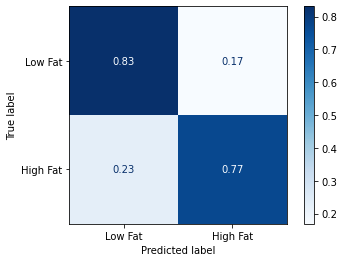

In [31]:
#Figure 9:Confusion Matrix for the Logistic Regression model. 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, random_search.predict(X_test), normalize="true")


cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Fat", "High Fat"])


cm_plot.plot(cmap="Blues", values_format=".2f")

The confusion matrix (Figure 9) shows that the model correctly classified 83% of low-fat cheeses (true positives) and 77% of high-fat cheeses (true negatives). This indicates that the balanced logistic regression model performs well across both classes, with slightly stronger accuracy in identifying low-fat cheeses. The misclassifications (17% and 23%) suggest some overlap between the two categories, which could be due to shared feature characteristics among certain cheese types.

Finally, a classification report will be made.

In [32]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    random_search.predict(X_test),
    target_names=["Low Fat", "High Fat"]
))

              precision    recall  f1-score   support

     Low Fat       0.87      0.83      0.85       136
    High Fat       0.71      0.77      0.74        73

    accuracy                           0.81       209
   macro avg       0.79      0.80      0.79       209
weighted avg       0.81      0.81      0.81       209



The classification report indicates that the balanced logistic regression model achieved an overall accuracy of 81%. The precision scores were 87% for low-fat cheese and 71% for high-fat cheese, suggesting that the model is more confident and accurate in identifying low-fat samples. Similarly, the recall scores were 83% for low-fat and 77% for high-fat cheese, showing that the model correctly recognized the majority of samples in both categories. The F1-scores followed a similar trend, with values of 85% for low-fat and 74% for high-fat cheese. Overall, these results suggest that while the model performs well across both classes, it shows a slight bias toward predicting low-fat cheese more accurately. These results are not surprising given the imbalanced nature of the data, as the target variable is more heavily distributed toward low-fat cheese.

## Final consideration
To further evaluate the impact of the text feature, all model computations were repeated after removing the CheeseName variable from the preprocessing pipeline. The resulting performance metrics for both the unbalanced and balanced logistic regression models are shown below.

In [33]:
#Table 7: Unbalanced Scores for Logistic Regression Model without 'CheeseName'.
data ={'Unbalanced Scores': {0: 'fit_time',
  1: 'score_time',
  2: 'test_accuracy',
  3: 'train_accuracy',
  4: 'test_f1',
  5: 'train_f1',
  6: 'test_recall',
  7: 'train_recall',
  8: 'test_precision',
  9: 'train_precision'},
 'Number': {0: 0.015555477142333985,
  1: 0.006013727188110352,
  2: 0.7779164562441382,
  3: 0.8010202106154131,
  4: 0.6660339375531308,
  5: 0.6926381658325375,
  6: 0.6456140350877193,
  7: 0.6552631578947368,
  8: 0.6891968442915603,
  9: 0.7345597187853051}}
lr_unbalanced_df = pd.DataFrame(data)
lr_unbalanced_df

,Unbalanced Scores,Number
0,fit_time,0.015555
1,score_time,0.006014
2,test_accuracy,0.777916
3,train_accuracy,0.801020
4,test_f1,0.666034
5,train_f1,0.692638
6,test_recall,0.645614
7,train_recall,0.655263
8,test_precision,0.689197
9,train_precision,0.734560


In [34]:
#Table 8: balanced Scores for Logistic Regression Model without 'CheeseName'.
data ={'Balanced Scores': {0: 'fit_time',
  1: 'score_time',
  2: 'test_accuracy',
  3: 'train_accuracy',
  4: 'test_f1',
  5: 'train_f1',
  6: 'test_recall',
  7: 'train_recall',
  8: 'test_precision',
  9: 'train_precision'},
 'Number': {0: 0.01650409698486328,
  1: 0.00540471076965332,
  2: 0.7623115215352428,
  3: 0.7764095429762595,
  4: 0.687452958694422,
  5: 0.7080481087411987,
  6: 0.7614035087719297,
  7: 0.7921052631578948,
  8: 0.6269334625810129,
  9: 0.64021540306152}} 
lr_balanced_df = pd.DataFrame(data)
lr_balanced_df

,Balanced Scores,Number
0,fit_time,0.016504
1,score_time,0.005405
2,test_accuracy,0.762312
3,train_accuracy,0.776410
4,test_f1,0.687453
5,train_f1,0.708048
6,test_recall,0.761404
7,train_recall,0.792105
8,test_precision,0.626933
9,train_precision,0.640215


As observed (Tables 7 and 8), removing the CheeseName feature led to a consistent decrease in test and training accuracy for both model variants when compared to the full model that included the text feature. The decline is particularly evident in the recall, F1, and precision scores, suggesting that the text-based information contributed meaningful discriminatory power to the classification process. This finding reinforces the importance of incorporating structured text features in machine learning pipelines when they capture domain-relevant signals — in this case, cheese names that often imply production style, fat content, or brand-specific characteristics.

These results provided a strong foundation for interpreting the overall model performance. The observed decline after removing the text feature underscored the significant predictive value of text-based information within this dataset. This insight informed the subsequent discussion on feature importance and model interpretability, clarifying how different variable types contributed to the classifier’s success.

# Discussion
Overall, the balanced logistic regression model achieved the best trade-off between accuracy and fairness, correctly classifying most cheese samples across both fat-level categories. The use of class weighting and hyperparameter tuning improved minority class recall without overfitting, meeting the project’s goal of developing a reliable and interpretable classifier for cheese fat content prediction. The final model reached an overall accuracy of 81% and demonstrated solid recall and F1-scores across both classes, confirming its ability to generalize well to unseen data.

Feature Importance and Model Interpretability

To better understand which features most strongly influenced the predictions, the feature importance scores from the logistic regression coefficients were examined. The analysis revealed that the MoisturePercent feature and certain cheese name tokens derived from the CheeseName text vectorization contributed significantly to the classification outcome. Additionally, categorical features such as MilkTreatmentTypeEn (pasteurized vs. raw) and CategoryTypeEn (firm vs. soft cheese) showed meaningful associations with fat level, consistent with general expectations in dairy product composition — firmer and pasteurized cheeses tend to have higher fat levels. This alignment between model findings and domain intuition strengthens confidence in the model’s interpretability.

Limitations and Sources of Bias

Despite strong results, several limitations should be acknowledged. The dataset exhibits a notable class imbalance, with a predominance of low-fat cheeses, which may bias the model toward predicting the majority class. Although class weighting mitigated this issue, further techniques such as resampling could be explored. Moreover, the dataset includes potential inconsistencies in text data (e.g., varied spellings or formats in CheeseName), which could dilute the effectiveness of the text vectorization process. The relatively small number of numeric features also restricts the model’s capacity to capture continuous relationships that may affect fat level.

Potential Improvements and Future Work

Future work could explore more complex algorithms such as Random Forests or Support Vector Machines to test whether non-linear relationships improve predictive performance. Finally, expanding the dataset with more balanced samples across provinces, milk types, and cheese categories could improve model robustness and generalizability.

In summary, this study successfully demonstrated that supervised machine learning—specifically, a balanced logistic regression pipeline—can effectively classify Canadian cheeses by fat content using a combination of numerical, categorical, binary, and text features. While the model shows high accuracy and interpretability, addressing data imbalance and exploring advanced feature engineering methods could further enhance performance. These findings underscore the potential of machine learning for structured food classification tasks and highlight areas for continued refinement.

# References

Government of Canada. (2024). Dairy industry overview. Canadian Dairy Information Centre. Retrieved from https://agriculture.canada.ca/en/sector/animal-industry/canadian-dairy-information-centre/dairy-industry

Scikit-learn developers. CountVectorizer — Feature extraction from text. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Scikit-learn developers. Working with text data. Retrieved from https://scikit-learn.org/1.4/tutorial/text_analytics/working_with_text_data.html

Scikit-learn developers. Working with functional transformer. Retrieved from https://scikit-learn.org/0.20/modules/generated/sklearn.preprocessing.FunctionTransformer.html

Müller, A. Advanced topics — Working with text data (Bag of Words). Retrieved from https://amueller.github.io/aml/05-advanced-topics/13-text-data.html

University of British Columbia. (UBC). Introduction to Machine Learning — Module 6: Preprocessing and Variable Types. Retrieved from https://ubc-mds.github.io/introduction-machine-learning/modules/module6/module6-00-module_learning_outcomes.html

University of British Columbia. (UBC). Introduction to Machine Learning — Module 7: Model Evaluation and Imbalanced Datasets. Retrieved from https://ubc-mds.github.io/introduction-machine-learning/modules/module7/module7-00-module_learning_outcomes.html

University of British Columbia. (UBC). Introduction to Machine Learning — Module 8: Feature Engineering and Model Optimization. Retrieved from https://ubc-mds.github.io/introduction-machine-learning/modules/module8/module8-00-module_learning_outcomes.html